# Multi-label classification on VSM

In [2]:
#loading required modules
import random
import socket
import os
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
import sklearn.decomposition
#import brewer2mpl
import pandas
from pandas.tools.plotting import parallel_coordinates
import vsmlib
import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline
mpl.style.use('bmh')

## loading the model data

In [3]:
if socket.gethostname()=="cypress":
    #dir_root="/storage/scratch/SVD/explicit_BNC_w3_pos_svd_400_C0.1/"    
    dir_root="/storage/scratch/SVD/Russian/proza.ru/lemmas/explicit_proza.ru_lemmas_w2_svd_500_C0.6/"
if socket.gethostname()=="ashtree":  
    dir_root="/mnt/work/nlp_scratch/SVD/Rus/proza.ru/explicit_proza.ru_raw_w2_svd_500_C0.6/"
    #dir_root="/mnt/work/nlp_scratch/test"
if socket.gethostname()=="rc017.m.gsic.titech.ac.jp":
    dir_root="/home/blackbird/data/scratch/SVD/Russian/proza.ru/raw/explicit_proza.ru_raw_w2_svd_500_C0.6/"    


In [4]:
m=vsmlib.model.load_from_dir(dir_root)
m.normalize()
print(m.provenance)

this is dense 
source corpus : /work/alex/data/corpora/lemmatized/Rus/proza.ru/
words in corpus : 1045299205
unique words : 4631021
minimal frequency: 30
unique words : 316809
windows size : 2
frequency weightening : PMI
applied scipy.linal.svd, 500 singular vectors, sigma in the power of 0.6
transform : normalized


## loading the classification data

In [5]:
#load from folder
def load_from_folder(path):
    files = [ f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f)) ]
    files
    df = pandas.DataFrame(columns=["word","class"])
    id_row=0;
    for i in (files):
        words = [s.strip() for s in open(os.path.join(path,i)).readlines()]
        for w in words:
            df.loc[id_row] = [w,i]
            id_row+=1
    return df

In [6]:
#load from csv
def load_from_csv(path):
    dfa = pandas.read_csv(path)
    df = pandas.DataFrame(columns=["word","class"])
    id_row=0;
    classes=[]
    for col in dfa:
        #print (col)
        classes.append(str(col))
        for word in dfa[col]:
            #if word != pandas.np.nan:
            if not pandas.isnull(word):
                #print(word)
                for token in word.split(","):
                    w=token.strip()
                    df.loc[id_row] = [w,col]
                    id_row+=1
    return df
#print ("missing words:",len(lst_missing_words))                   

In [7]:
df = load_from_folder("../data/multi_class/rus/")
df = load_from_csv("/home/blackbird/Cloud/Dropbox/Collaboration/Anna/Botva/RussianVerbs.csv")
classes=df["class"].unique()

## analysing coverage of labels with data

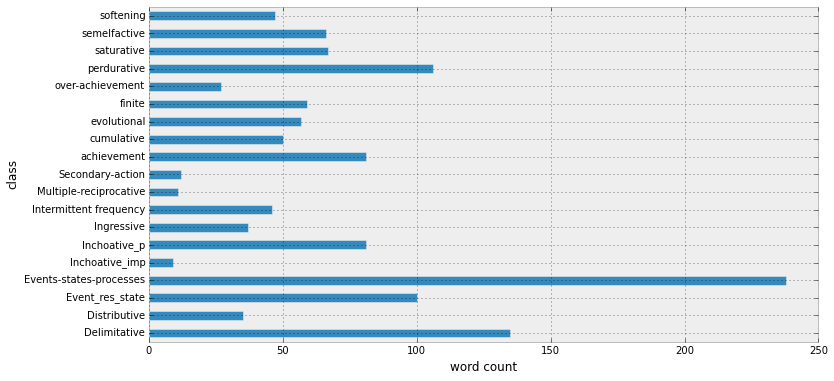

In [8]:
cnts = df.groupby("class").agg(pandas.Series.nunique)
mpl.rcParams['figure.figsize'] = (12.0, 6.0)
fig, ax = plt.subplots()
cnts.plot(kind="barh",legend=False,ax=ax)
ax.set_xlabel("word count");

In [9]:
# filter missing words and generate feature-vectors
lst_missing_words=[]
rows = np.empty((0,m.matrix.shape[1]))
y=[]
for i in zip(df["word"],df["class"]):
    if m.vocabulary.get_id(i[0])>=0:
        rows =np.vstack([rows,m.get_row(i[0])])
        y.append(i[1])
    else:
        lst_missing_words.append(i[0])
print("missing words : ", len(lst_missing_words))

missing words :  231


In [10]:
#vis statistics on words

## Trying to learn classes with multy-label logistic regression

In [11]:
model = LogisticRegression()
#random.shuffle(y)
#y=np.asarray([0]*rows.shape[0])
x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(rows, y, test_size=0.25, random_state=42)
model.fit(x_train,y_train)
print ("train score",model.score(x_train,y_train))
print ("test score",model.score(x_test,y_test))

train score 0.796437659033
test score 0.653992395437


In [12]:
cnt_mispredicted=0
for i in range(rows.shape[0]):
    predicted = model.predict(rows[i])[0]
    if  predicted != y[i]:
        print ("{:>15} - predicted {} but should be {}".format(df["word"][i],predicted,y[i]))
        cnt_mispredicted+=1
    if cnt_mispredicted>10: break


     полеживать - predicted Events-states-processes but should be Intermittent frequency
   поговаривать - predicted Events-states-processes but should be Intermittent frequency
     попахивать - predicted Events-states-processes but should be Intermittent frequency
    покрикивать - predicted Events-states-processes but should be Intermittent frequency
     подумывать - predicted Events-states-processes but should be Intermittent frequency
    повоевывать - predicted Events-states-processes but should be Intermittent frequency
     погуливать - predicted Events-states-processes but should be Intermittent frequency
     помахивать - predicted Events-states-processes but should be Intermittent frequency
     пописывать - predicted Events-states-processes but should be Intermittent frequency
     поругивать - predicted Events-states-processes but should be Intermittent frequency
     покашивать - predicted Events-states-processes but should be Intermittent frequency


## reducing dimensions and plotting first N in parallel coordinates

In [13]:
pca = sklearn.decomposition.PCA(n_components=7,whiten=True)
p = pca.fit_transform(rows)

In [14]:
text_color="#cccccc"
def set_ax_params(ax):
    ax.spines['bottom'].set_color(text_color)
    ax.spines['top'].set_color(text_color)
    ax.spines['left'].set_color(text_color)
    ax.spines['right'].set_color(text_color)
    ax.tick_params(colors=text_color)
text_color="black"

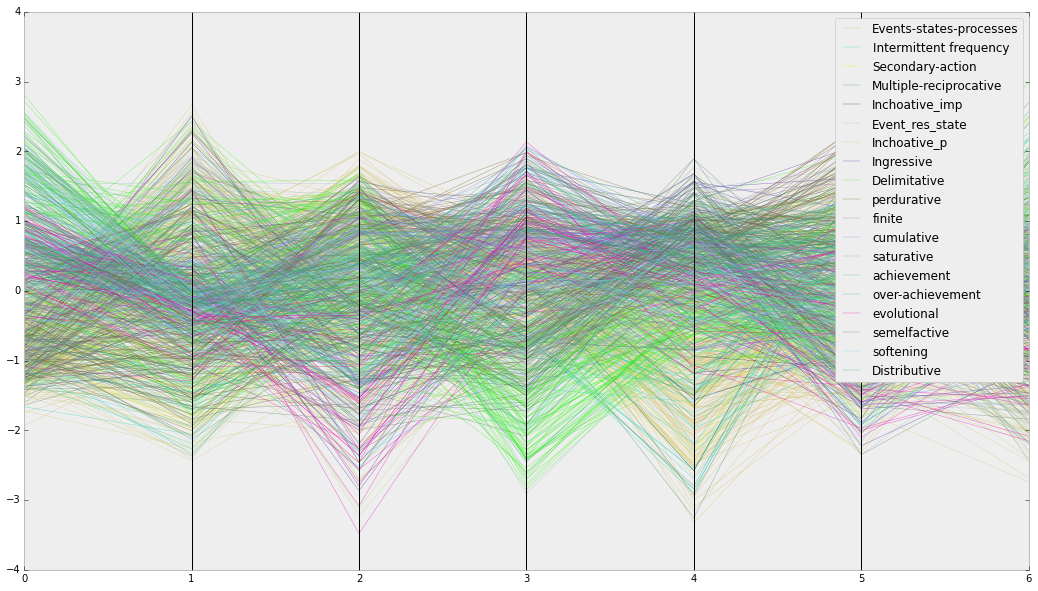

In [17]:
mpl.rcParams['figure.figsize'] = (18.0, 10.0)
df_pca=pandas.DataFrame(p,index=y)
df_pca.reset_index(level=0, inplace=True)
parallel_coordinates(df_pca,"index",alpha=0.7,linewidth=0.4)
#plt.savefig("parallel_multy_"+m.name+"_verbs.pdf", bbox_inches='tight',transparent=True)

## plotting a 2D projection with PCA

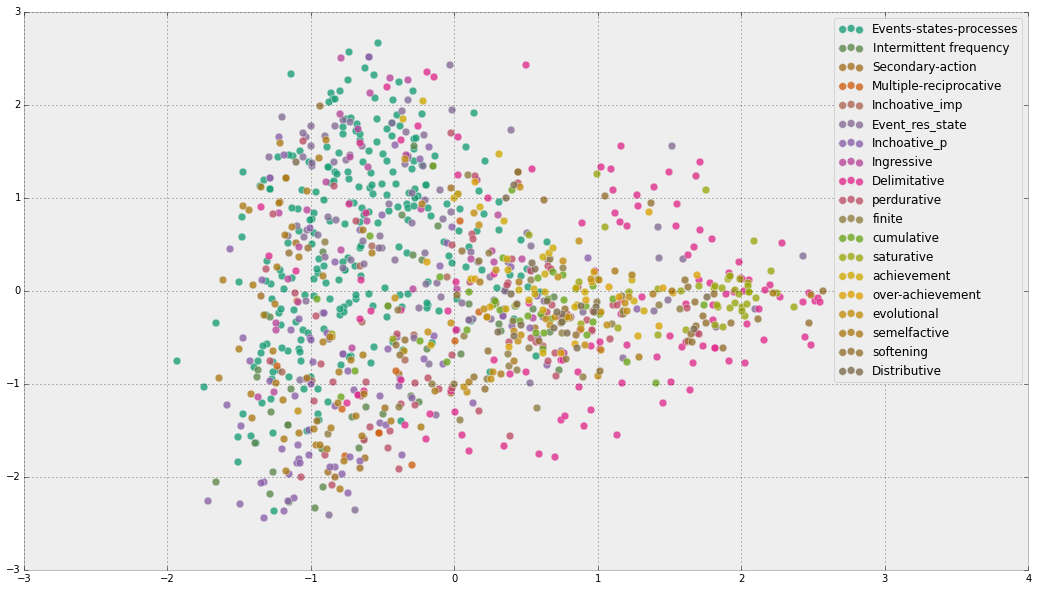

In [101]:
fig, ax = plt.subplots()
#colors = brewer2mpl.get_map('Set1', 'Qualitative', 9).mpl_colors
colors=[mpl.cm.Dark2(c/len(classes)) for c in range(len(classes))]
col=0;
for i in classes:
    plt.scatter(df_pca[df_pca["index"]==i][0],df_pca[df_pca["index"]==i][1],c=colors[col],alpha=0.8,s=60,label=i)
    col+=1
    #df_pca[df_pca["index"]==i].plot(kind="scatter",x=0,y=1,color=colors[i],ax=ax,label=files[i])
#for i in range(rows.shape[0]):
#    predicted = model.predict(rows[i])[0]
#    if  predicted != y[i]:
#        print (df_pca.loc[i][0],df_pca.loc[i][1])
#        circle1=plt.Circle((df_pca.loc[i][0],df_pca.loc[i][1]),0.05,color=colors[int(predicted)],alpha=0.2)
#        fig.gca().add_artist(circle1)
#        plt.text(df_pca.loc[i][0]-0.1,df_pca.loc[i][1]-0.1,df["word"][i])
plt.legend()
#plt.savefig("scatter_multy_"+m.name+".pdf")

## do supervised 2D projection with LDA
linear discriminant analyss that is, not latent Dirichlet allocation